In [1]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean, pdist, squareform
from Bio import SeqIO
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary, calculate_mutspec
from pymutspec.io import read_rates, GenesStates
from pymutspec.constants import possible_sbs192, possible_sbs12

%matplotlib inline

In [6]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        altnodes  = obs.index.get_level_values(1).values
        obs_edges = obs
        freqs_nodes = exp
        obs_edges.index = obs_edges.index.reorder_levels(order=["AltNode", "RefNode"])
        freqs_nodes.index.name = "RefNode"
    else:
        altnodes = obs.AltNode.unique()
        obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    edges_sample_size = int(len(altnodes) * frac)
    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = freqs_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)


def collapse_sbs192(df: pd.DataFrame, to=12):
    assert (df.columns == possible_sbs192).all()
    df = df.copy()
    if to == 12:
        for sbs192 in possible_sbs192:
            sbs12 = sbs192[2:5]
            if sbs12 in df.columns.values:
                df[sbs12] += df[sbs192]
            else:
                df[sbs12] = df[sbs192]

        return df[possible_sbs12]
    else:
        raise NotImplementedError()


def calc_edgewise_spectra(obs: pd.DataFrame, exp: pd.DataFrame, nmtypes_cutoff=16, nobs_cuttof=20, collapse_to_12=False, scale=True, both_12_and_192=False):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        obs_edges = obs
        freqs_nodes = exp
        freqs_nodes.index.name = "RefNode"
    else:
        obs_edges = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
        freqs_nodes.index.name = "RefNode"
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    if not collapse_to_12:
        obs_edges = obs_edges[((obs_edges > 0).sum(axis=1) >= nmtypes_cutoff) & (obs_edges.sum(axis=1) > nobs_cuttof)]
    
    edges_df = obs_edges.index.to_frame(False)

    freqs_edges = edges_df.merge(freqs_nodes, on="RefNode")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    
    assert (obs_edges.columns == freqs_edges.columns).all()
    assert (obs_edges.index == freqs_edges.index).all()

    if both_12_and_192:
        obs_edges12   = collapse_sbs192(obs_edges.fillna(0.),   to=12)
        freqs_edges12 = collapse_sbs192(freqs_edges.fillna(0.), to=12)

        spectra12 = (obs_edges12 / freqs_edges12).replace(np.inf, 0.).fillna(0.)
        spectra192 = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
        if scale:
            spectra12 = (spectra12.T / spectra12.T.sum(axis=0)).T
            spectra192 = (spectra192.T / spectra192.T.sum(axis=0)).T

        spectra12 = spectra12.fillna(0)
        spectra192 = spectra192.fillna(0)
        assert not (spectra12 == np.inf).any().any()
        assert not (spectra12.isna()).any().any()
        assert not (spectra192 == np.inf).any().any()
        assert not (spectra192.isna()).any().any()
        
        return spectra12, spectra192

    if collapse_to_12:
        obs_edges   = collapse_sbs192(obs_edges.fillna(0.),   to=12)
        freqs_edges = collapse_sbs192(freqs_edges.fillna(0.), to=12)

    spectra = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
    if scale:
        spectra = (spectra.T / spectra.T.sum(axis=0)).T

    spectra = spectra.fillna(0)
    assert not (spectra == np.inf).any().any()
    assert not (spectra.isna()).any().any()
    return spectra


def assign_cat(p: float, interval=0.1):
    if interval < 0.01:
        raise NotImplementedError
    
    left = p // interval / (1 / interval)
    right = left + interval
    if interval >= 0.1:
        return f"{left:.1f}_{right:.1f}"
    else:
        return f"{left:.2f}_{right:.2f}"


def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    
    common_index = a.index.intersection(b.index)
    if len(common_index) == 0:
        return pd.Series()
    
    a = a.loc[common_index]
    b = b.loc[common_index]

    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

In [7]:
coda = CodonAnnotation(2)

## Mammals tree

### Load and Preprocess data

In [20]:
cols_rec_obs = ["Mut", "Label", "PosInGene", "ProbaFull", "RefNode", "AltNode"]
cols_gt_obs  = ["Mut", "Label", "PosInGene", "RefNode", "AltNode"]
cols_rec_exp = ["Mut", "Label", "Pos", "Proba", "Node"]
cols_gt_exp  = ["Mut", "Label", "Pos",  "Node"]

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}


def compare_mam_spectra(cond, pcutoff=0.3, categories=[4, 5, 6], nmtypes_cutoff=16, nobs_cuttof=20, only_raw=False):
    path_to_rates   = f"../data/alisim/spectra_reconstructed_mam/{cond}/IQTREE/anc.rate"
    path_to_mapping = f"../data/alisim/spectra_reconstructed_mam/{cond}/sequences/species_mapping.txt"

    path_to_rec_obs = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/mutations.tsv"
    path_to_rec_exp = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/expected_mutations.tsv"
    path_to_gt_obs  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutations.tsv"
    path_to_gt_exp  = f"../data/alisim/spectra_groundtruth_mam/{cond}/expected_mutations.tsv"

    if os.path.exists(path_to_mapping) and os.path.exists(path_to_rec_exp) and os.path.exists(path_to_gt_exp):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)

        rec_obs = pd.read_csv(path_to_rec_obs, sep="\t", usecols=cols_rec_obs)
        rec_exp = pd.read_csv(path_to_rec_exp, sep="\t", usecols=cols_rec_exp)
        gt_obs  = pd.read_csv(path_to_gt_obs,  sep="\t", usecols=cols_gt_obs)
        gt_exp  = pd.read_csv(path_to_gt_exp,  sep="\t", usecols=cols_gt_exp)
        rates   = pd.read_csv(path_to_rates,   sep="\t", comment="#")

        rec_obs = rec_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        rec_exp = rec_exp.merge(rates[["Site", "Cat"]], left_on="Pos", right_on="Site").drop("Pos", axis=1)
        gt_obs  = gt_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        gt_exp  = gt_exp.merge(rates[["Site", "Cat"]], left_on="Pos", right_on="Site").drop("Pos", axis=1)

        # replace encoded node names
        gt_obs["AltNode"] = gt_obs.AltNode.map(name2id)

        if only_raw:
            return rec_obs, rec_exp, gt_obs, gt_exp

        #prepare OBS
        rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat.isin(categories))]
        rec_obs_syn = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 1) & (rec_obs.Cat.isin(categories))]
        gt_obs_all = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat.isin(categories))].assign(ProbaFull=1.0)
        gt_obs_syn = gt_obs[(gt_obs.Label >= 1) & (gt_obs.Cat.isin(categories))].assign(ProbaFull=1.0)

        #prepare EXP
        rec_exp_all = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Label.astype("category") == "all") & (rec_exp.Cat.isin(categories))]
        rec_exp_syn = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Label.astype("category") == "syn") & (rec_exp.Cat.isin(categories))]
        gt_exp_all = gt_exp[(gt_exp.Label.astype("category") == "all") & (gt_exp.Cat.isin(categories))].assign(Proba=1.0)
        gt_exp_syn = gt_exp[(gt_exp.Label.astype("category") == "syn") & (gt_exp.Cat.isin(categories))].assign(Proba=1.0)
        
        #calc tree spectra
        HERE IS THE EXCEPTION, some dataframe has no rows???
        rec_all_spectra12, rec_all_spectra192 = calc_edgewise_spectra(rec_obs_all, rec_exp_all, nmtypes_cutoff, nobs_cuttof, both_12_and_192=True)
        gt_all_spectra12, gt_all_spectra192   = calc_edgewise_spectra(gt_obs_all,  gt_exp_all,  nmtypes_cutoff, nobs_cuttof, both_12_and_192=True)
        rec_syn_spectra12, rec_syn_spectra192 = calc_edgewise_spectra(rec_obs_syn, rec_exp_syn, nmtypes_cutoff, nobs_cuttof, both_12_and_192=True)
        gt_syn_spectra12, gt_syn_spectra192   = calc_edgewise_spectra(gt_obs_syn,  gt_exp_syn,  nmtypes_cutoff, nobs_cuttof, both_12_and_192=True)

        #get cossim
        cossim12_all  = get_cossim(gt_all_spectra12,  rec_all_spectra12).rename("cossim12_all").reset_index()
        cossim192_all = get_cossim(gt_all_spectra192, rec_all_spectra192).rename("cossim192_all").reset_index()
        cossim12_syn  = get_cossim(gt_syn_spectra12,  rec_syn_spectra12).rename("cossim12_syn").reset_index()
        cossim192_syn = get_cossim(gt_syn_spectra192, rec_syn_spectra192).rename("cossim192_syn").reset_index()
    
        if len(cossim12_all) == 0 or len(cossim12_syn) == 0:
            return
        
        total_cossim = cossim12_all.merge(cossim12_syn, "outer", on=["RefNode", "AltNode"])

        if len(cossim192_all):
            total_cossim = total_cossim.merge(cossim192_all, "outer", on=["RefNode", "AltNode"])
        if len(cossim192_syn):
            total_cossim = total_cossim.merge(cossim192_syn, "outer", on=["RefNode", "AltNode"])
        
        cat_lbl = 'cat' + ''.join(str(x) for x in categories)
        return total_cossim.assign(Cond=cond, Cat=cat_lbl)

In [18]:
samples = [d.split("/")[-1] for d in glob.glob("../data/alisim/spectra_reconstructed_mam/*")]
one = compare_mam_spectra(samples[0], 0.3, [4,5,6], 5, 5)
print(samples[:5])
one.head()

['gtr_mam_cytb_replica_18', 'gtr_mam_rnd_replica_4', '12.12_mam_rnd_replica_15', 'gtr_mam_rnd_replica_26', '12.12_mam_cytb_replica_4']


,RefNode,AltNode,cossim12_all,cossim12_syn,cossim192_all,cossim192_syn,Cond,Cat
0,Node10,Node11,0.938734,NaN,0.753140,NaN,gtr_mam_cytb_replica_18,Cat456
1,Node10,Node40,0.885057,NaN,0.601145,NaN,gtr_mam_cytb_replica_18,Cat456
2,Node100,Node101,0.767427,NaN,0.818125,NaN,gtr_mam_cytb_replica_18,Cat456
3,Node100,RN_94,0.971122,0.923177,0.894590,0.841255,gtr_mam_cytb_replica_18,Cat456
4,Node1000,Node1001,0.999542,NaN,0.989377,NaN,gtr_mam_cytb_replica_18,Cat456


<AxesSubplot:xlabel='metrica', ylabel='value'>

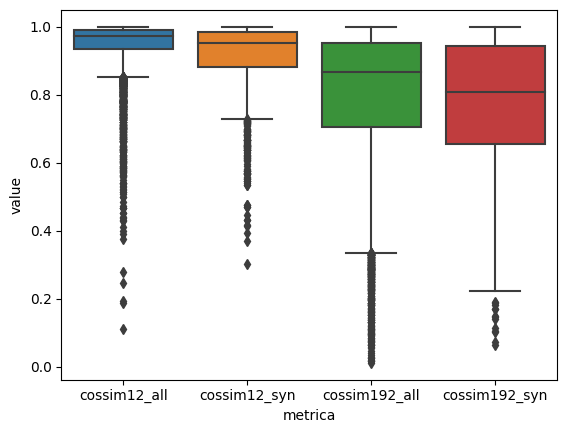

In [11]:
sns.boxplot(data=one.melt(["RefNode", "AltNode"], ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], "metrica"), x="metrica", y="value")

### slightly explore data

In [12]:
rec_obs, rec_exp, gt_obs, gt_exp = compare_mam_spectra(samples[0], only_raw=True)

In [13]:
rec_obs[rec_obs.ProbaFull > 0.3].groupby(["Cat", "AltNode"]).ProbaFull.sum().mean(level=0)#.hist(bins=50)

Cat
1    1.812636
2    3.285983
3    4.415482
4    5.436690
5    7.287127
6    7.081877
Name: ProbaFull, dtype: float64

In [14]:
# TODO calculate IoU for each
a = gt_obs[(gt_obs.AltNode == "Node801") & (gt_obs.Label >= 0)]
b = rec_obs[(rec_obs.AltNode == "Node801") & (rec_obs.Label >= 0) & (rec_obs.ProbaFull > 0.3)]

c = pd.merge(a, b, "outer", on=['Mut', 'Label', 'Site'])
c

,Mut,Label,RefNode_x,AltNode_x,Site,Cat_x,ProbaFull,RefNode_y,AltNode_y,Cat_y
0,G[C>A]T,2,Node747,Node801,501,4.0,0.744982,Node747,Node801,4.0
1,A[G>T]C,0,Node747,Node801,635,5.0,0.941088,Node747,Node801,5.0
2,A[C>A]T,0,Node747,Node801,1112,5.0,NaN,NaN,NaN,NaN
3,A[C>A]C,0,Node747,Node801,126,6.0,0.912476,Node747,Node801,6.0
4,G[A>G]C,0,Node747,Node801,317,2.0,0.955379,Node747,Node801,2.0
5,T[G>C]T,0,Node747,Node801,552,6.0,0.841552,Node747,Node801,6.0
6,C[A>C]C,0,Node747,Node801,829,6.0,0.906378,Node747,Node801,6.0
7,C[A>C]C,0,Node747,Node801,5,1.0,0.936491,Node747,Node801,1.0
8,T[T>G]T,0,Node747,Node801,308,5.0,0.955369,Node747,Node801,5.0
9,A[G>A]A,0,Node747,Node801,340,5.0,0.934109,Node747,Node801,5.0


<AxesSubplot:>

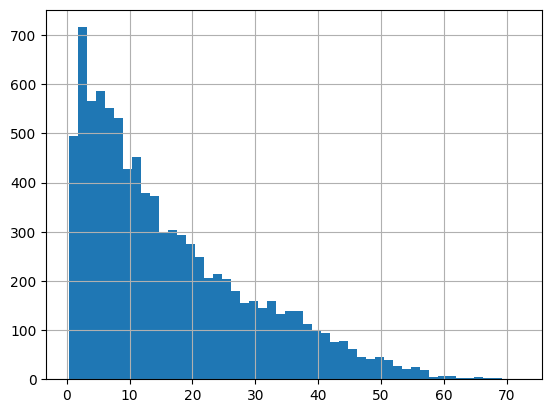

In [109]:
rec_obs[(rec_obs.ProbaFull > 0.3) & (rec_obs.Label >= 0) & (rec_obs.Cat >= 4)].groupby("AltNode").ProbaFull.sum().hist(bins=50)

<AxesSubplot:>

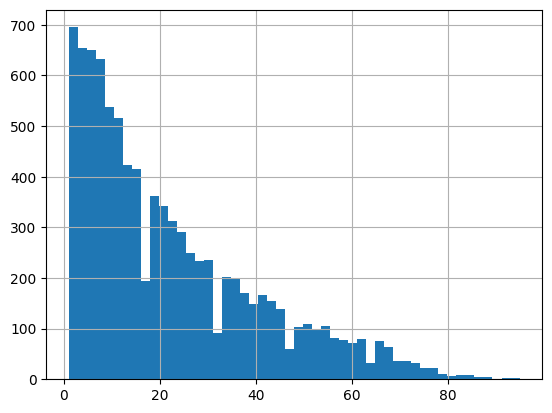

In [49]:
gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= 4)].groupby("AltNode").Mut.count().hist(bins=50)

#### OBS and EXP cossims

In [50]:
pcutoff = 0.3
cat_cutoff = 4

#prepare OBS
rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat >= cat_cutoff)]
gt_obs_all = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)

#prepare EXP
rec_exp_all = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Label.astype("category") == "all") & (rec_exp.Cat >= cat_cutoff)]
gt_exp_all = gt_exp[(gt_exp.Label.astype("category") == "all") & (gt_exp.Cat >= cat_cutoff)].assign(Proba=1.0)

Text(0.5, 1.0, 'distribution of cossim of OBSERVED: reconstructed VS ground truth 12 comp')

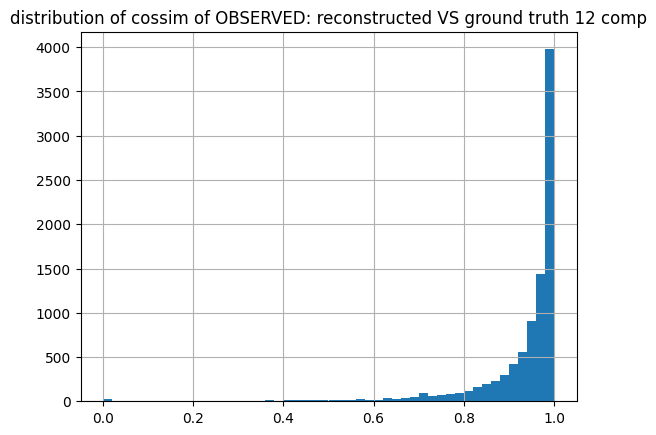

In [51]:
get_cossim(
    collapse_sbs192(rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192]),
    collapse_sbs192(gt_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192]),
).hist(bins=50)
plt.title("distribution of cossim of OBSERVED: reconstructed VS ground truth 12 comp")

Text(0.5, 1.0, 'distribution of cossim of EXPECTED: reconstructed VS ground truth 12 comp')

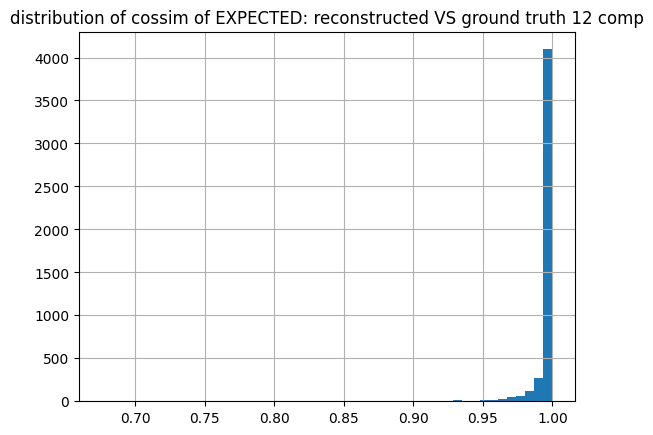

In [52]:
get_cossim(
    collapse_sbs192(rec_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack().fillna(0)[possible_sbs192]),
    collapse_sbs192(gt_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack().fillna(0)[possible_sbs192]),
).hist(bins=50)
plt.title("distribution of cossim of EXPECTED: reconstructed VS ground truth 12 comp")

Text(0.5, 1.0, 'distribution of cossim of OBSERVED: reconstructed VS ground truth 192 comp')

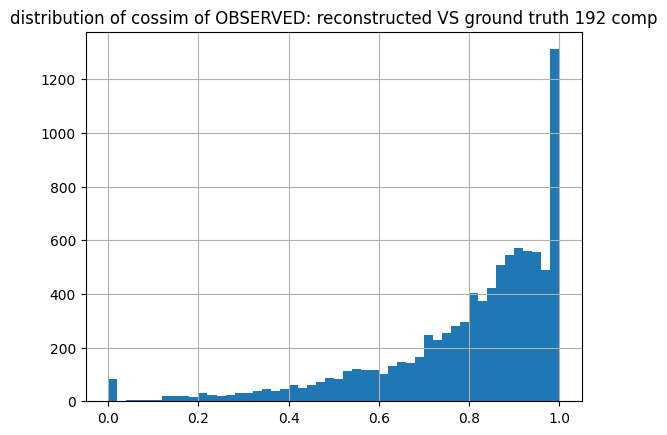

In [53]:
get_cossim(
    rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack(),
    gt_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack(),
).hist(bins=50)
plt.title("distribution of cossim of OBSERVED: reconstructed VS ground truth 192 comp")

Text(0.5, 1.0, 'distribution of cossim of EXPECTED: reconstructed VS ground truth 192 comp')

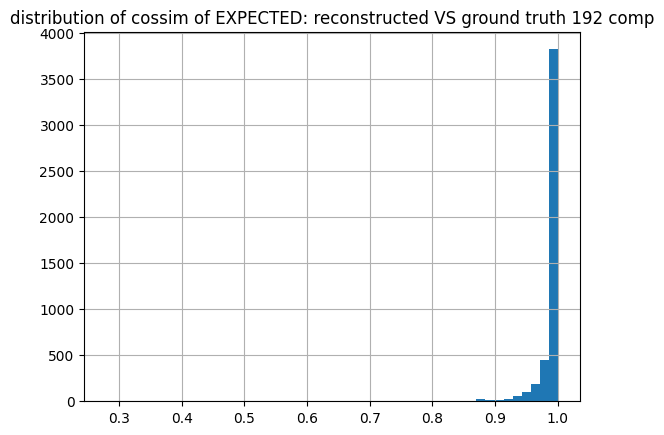

In [54]:
get_cossim(
    rec_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack(),
    gt_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack(),
).hist(bins=50)
plt.title("distribution of cossim of EXPECTED: reconstructed VS ground truth 192 comp")

OBS mutations were reconstructed with a lot of errors

### process

In [30]:
p = Pool(128)

In [25]:
raw_data456 = p.map(
    partial(compare_mam_spectra, categories=[4,5,6], nmtypes_cutoff=5, nobs_cuttof=5), 
    samples,
)

In [ ]:
raw_data123 = p.map(
    partial(compare_mam_spectra, categories=[1,2,3], nmtypes_cutoff=5, nobs_cuttof=5), 
    samples,
)

In [22]:
raw_data4 = p.map(
    partial(compare_mam_spectra, categories=[4], nmtypes_cutoff=5, nobs_cuttof=5), 
    samples,
)

KeyError: 'RefNode'

In [31]:
raw_data5 = p.map(
    partial(compare_mam_spectra, categories=[5], nmtypes_cutoff=5, nobs_cuttof=5), 
    samples,
)

In [32]:
raw_data6 = p.map(
    partial(compare_mam_spectra, categories=[6], nmtypes_cutoff=5, nobs_cuttof=5), 
    samples,
)

In [27]:
sum([isinstance(x, pd.DataFrame) for x in raw_data456])
# one replica has some reconstruction error

199

In [28]:
cossim456 = pd.concat(raw_data456).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metrica")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim456["replica"] = cossim456.Cond.apply(lambda x: x.split("_")[4])
cossim456["cond"] = cossim456.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])
cossim456.head()

,Cond,RefNode,AltNode,metrica,value,replica,cond
0,gtr_mam_cytb_replica_18,Node10,Node11,cossim12_all,0.938734,18,gtr-cytb
1,gtr_mam_cytb_replica_18,Node10,Node40,cossim12_all,0.885057,18,gtr-cytb
2,gtr_mam_cytb_replica_18,Node100,Node101,cossim12_all,0.767427,18,gtr-cytb
3,gtr_mam_cytb_replica_18,Node100,RN_94,cossim12_all,0.971122,18,gtr-cytb
4,gtr_mam_cytb_replica_18,Node1000,Node1001,cossim12_all,0.999542,18,gtr-cytb


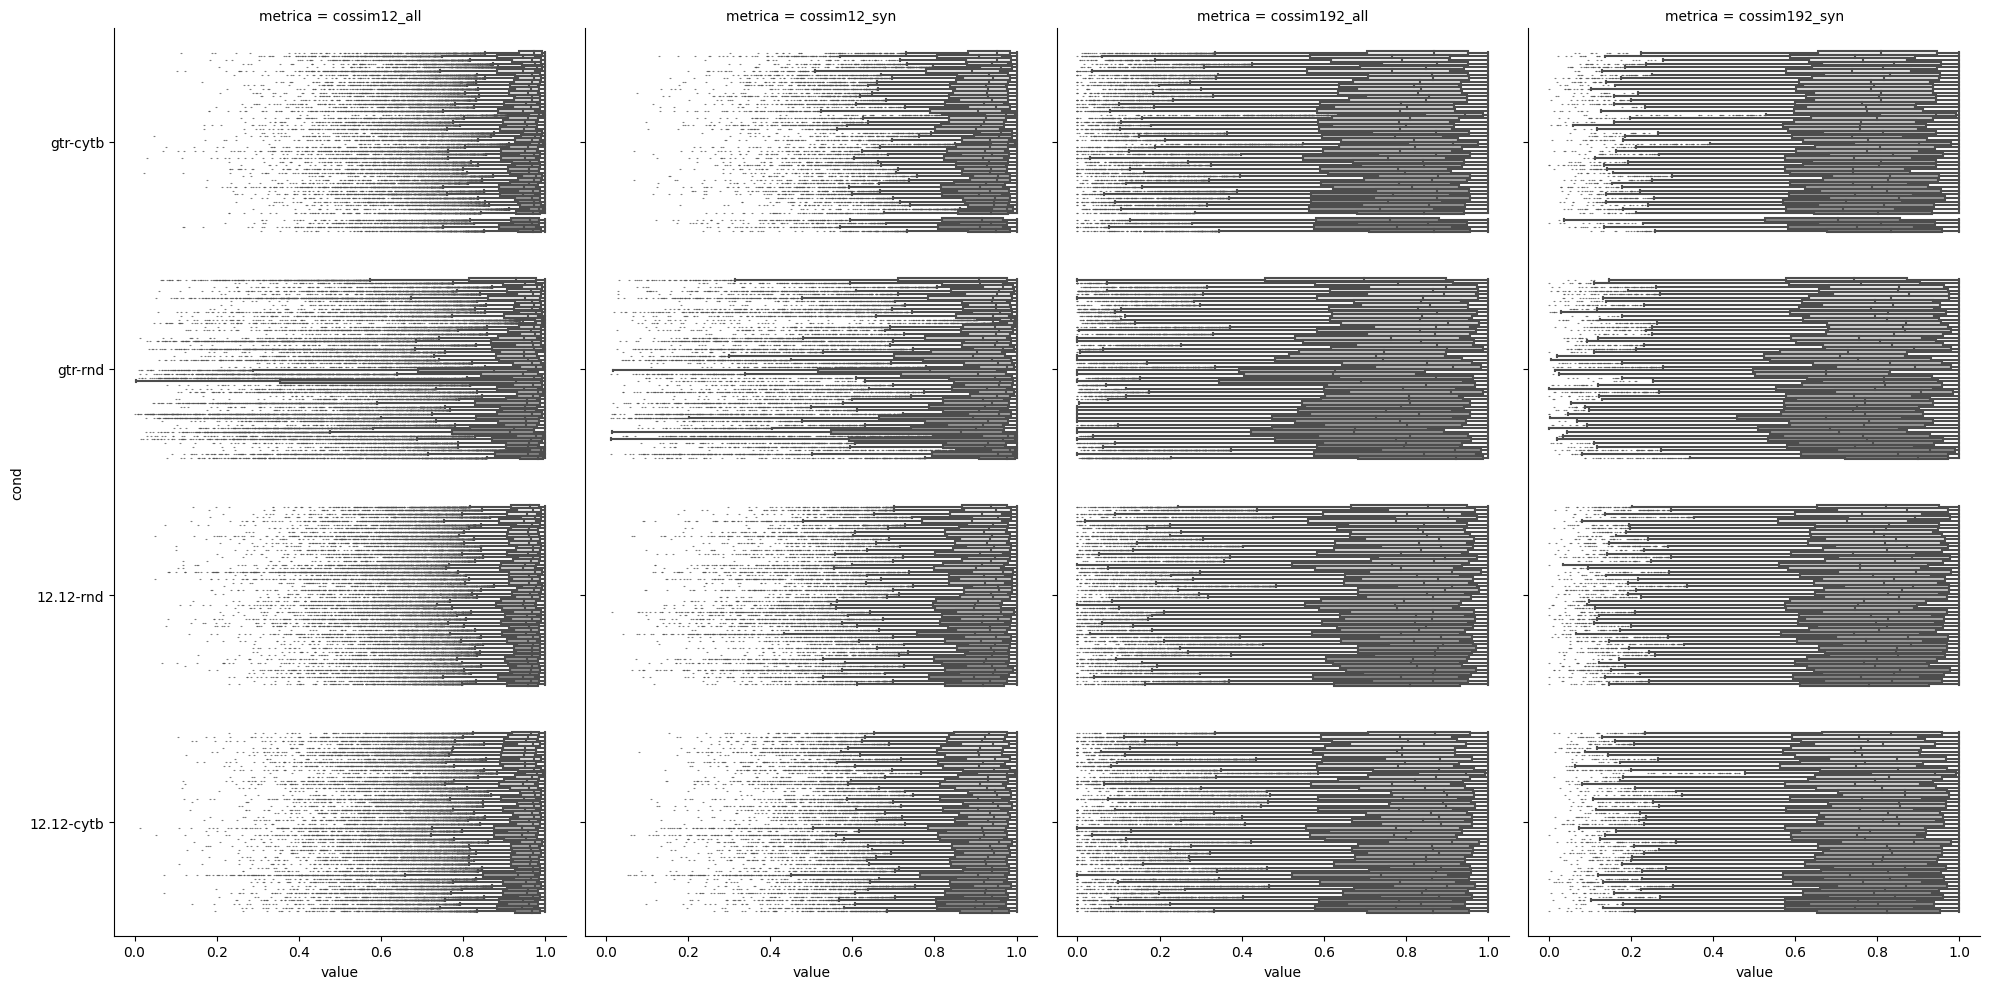

In [29]:
g = sns.catplot(
    data=cossim456, x="value", hue="replica", col="metrica", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_full_cat456.png")

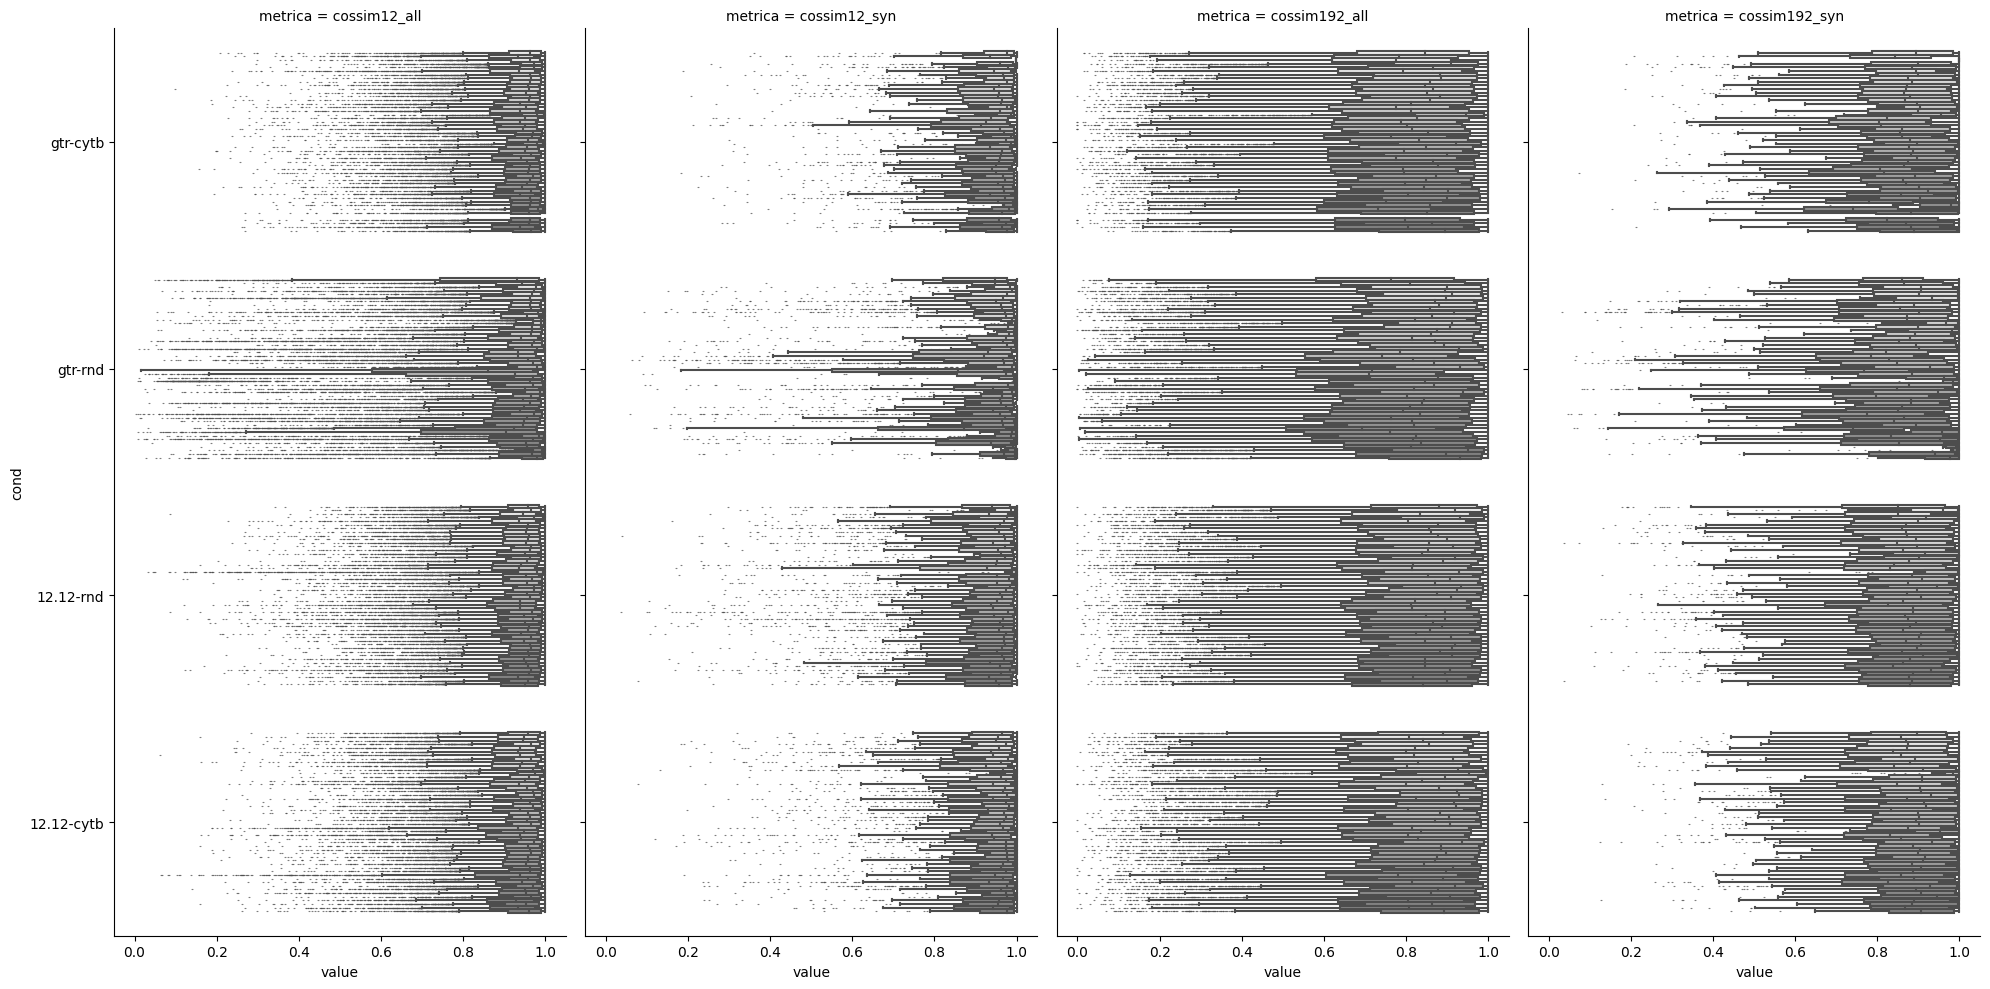

In [33]:
cossim5 = pd.concat(raw_data5).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metrica")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim5["replica"] = cossim5.Cond.apply(lambda x: x.split("_")[4])
cossim5["cond"] = cossim5.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim5, x="value", hue="replica", col="metrica", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_full_cat5.png")

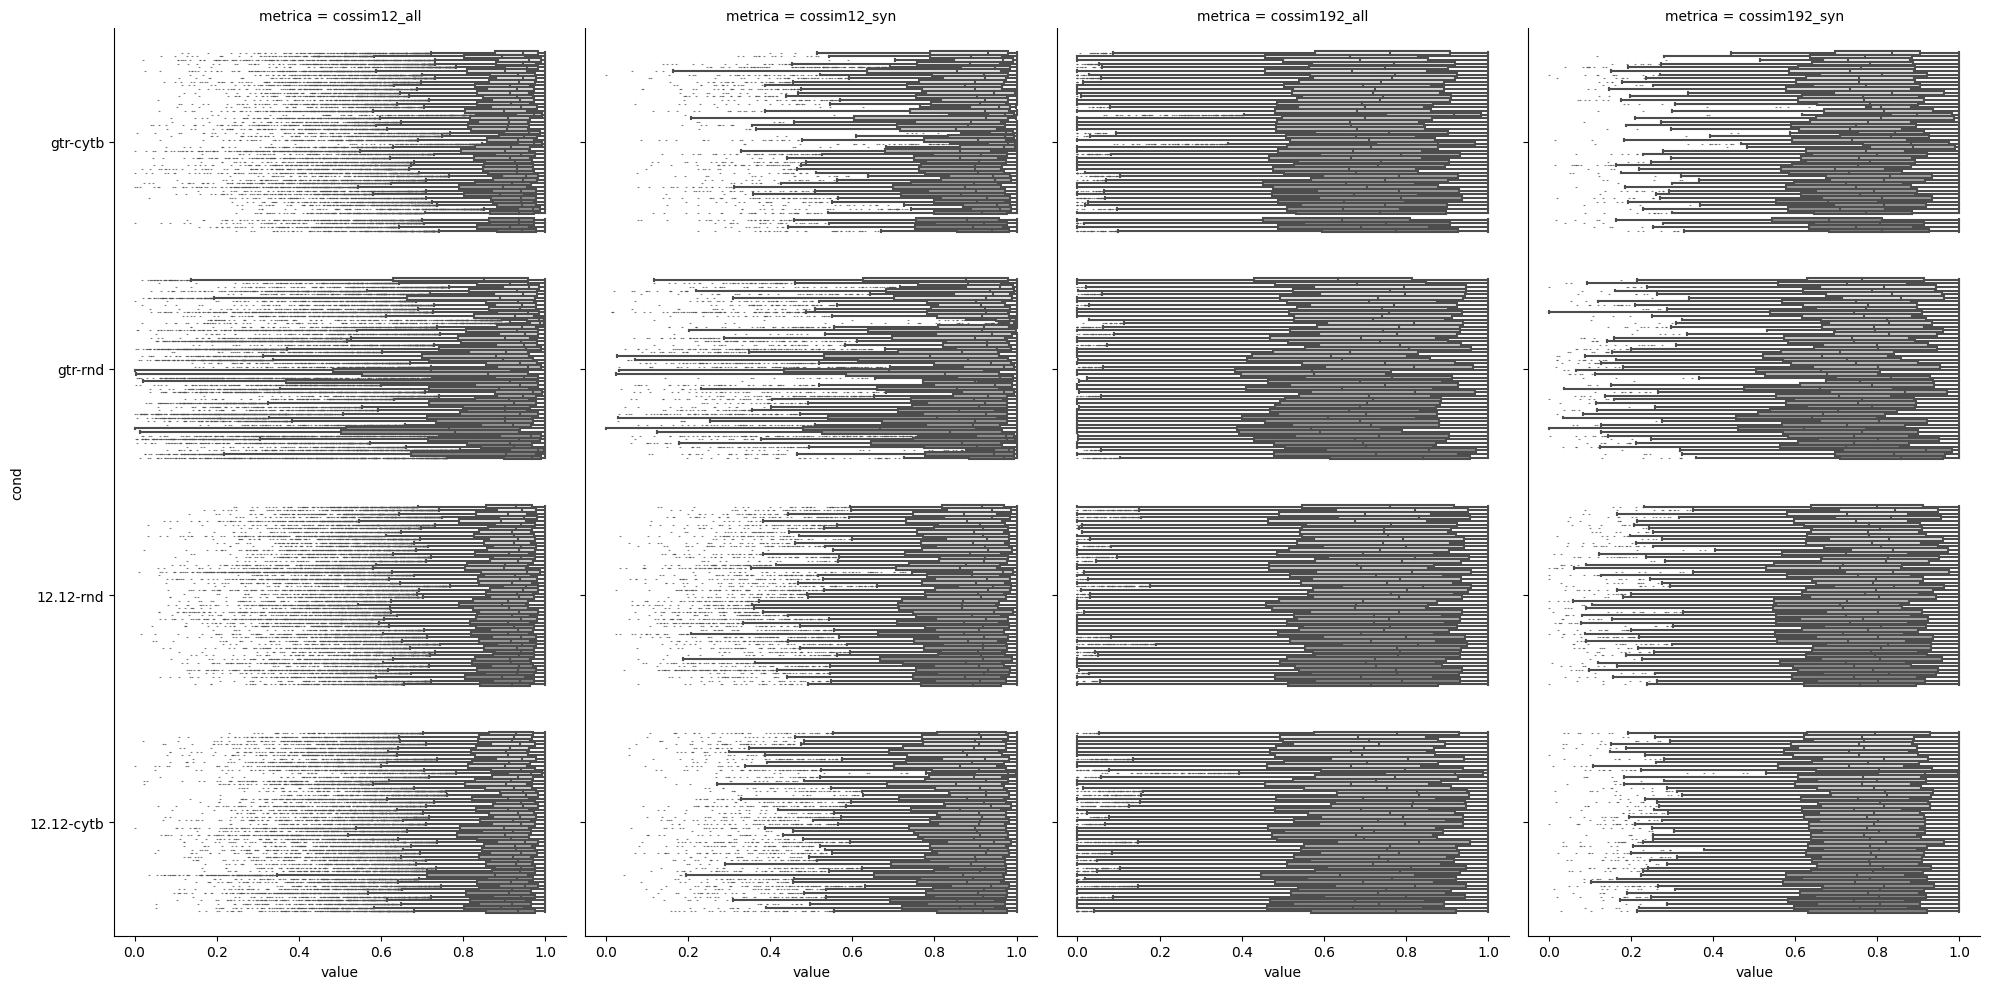

In [34]:
cossim6 = pd.concat(raw_data6).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metrica")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim6["replica"] = cossim6.Cond.apply(lambda x: x.split("_")[4])
cossim6["cond"] = cossim6.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim6, x="value", hue="replica", col="metrica", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_full_cat6.png")

In [ ]:
cossim = pd.concat(raw_data456 + raw_data123 + raw_data4, raw_data5, raw_data6).melt(
    ["Cond", "Cat", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metrica")
cossim["replica"] = cossim.Cond.apply(lambda x: x.split("_")[4])
cossim["cond"] = cossim.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])
cossim.head()

### Correlate edge cossim versus length

In [99]:
from ete3 import PhyloTree

path_to_tree = "../data/alisim/generations_mam/gtr_mam_cytb_replica_1.full.treefile"
tree = PhyloTree(path_to_tree, format=1)

edges = []
for i, node in enumerate(tree.iter_descendants()):
    # print(node.name, node.up.name, node.dist, )
    closest_leaf, d_to_leaf = node.up.get_closest_leaf()
    edges.append([
        node.up.name, 
        node.name, 
        node.dist, 
        closest_leaf.name, 
        d_to_leaf,
    ])
    # if i == 10:
    #     break

edges_df = pd.DataFrame(edges, columns=["RefNode", "AltNode", "d", "closest_leaf", "d_to_leaf"])
edges_df

,RefNode,AltNode,d,closest_leaf,d_to_leaf
0,ROOT,OUTGRP,1.50000,OUTGRP,1.50000
1,ROOT,Node4705,0.01000,OUTGRP,1.50000
2,Node4705,Node2,1.35799,gerbillus_occiduus,2.02331
3,Node4705,Node4,0.60502,gerbillus_occiduus,2.02331
4,Node2,Node3,0.54029,tachyglossus_aculeatus,0.66537
...,...,...,...,...,...
9405,Node1833,artibeus_planirostris_grenadensis,0.00338,artibeus_planirostris_fallax,0.00338
9406,Node3018,peromyscus_polionotus_peninsularis,0.00077,peromyscus_polionotus_peninsularis,0.00077
9407,Node3018,peromyscus_polionotus_trissyllepsis,0.00077,peromyscus_polionotus_peninsularis,0.00077
9408,Node3019,peromyscus_polionotus_ammobates,0.00092,peromyscus_polionotus_ammobates,0.00092


In [103]:
# cossim = 
pd.concat(raw_data).merge(edges_df[["AltNode", "d", "d_to_leaf"]], on="AltNode").corr("spearman")

,cossim12_all,cossim12_syn,cossim192_all,cossim192_syn,d,d_to_leaf
cossim12_all,1.000000,0.540121,0.671038,0.475829,-0.016756,-0.426740
cossim12_syn,0.540121,1.000000,0.534482,0.656736,-0.308253,-0.456969
cossim192_all,0.671038,0.534482,1.000000,0.659227,-0.267922,-0.625622
cossim192_syn,0.475829,0.656736,0.659227,1.000000,-0.407494,-0.562619
d,-0.016756,-0.308253,-0.267922,-0.407494,1.000000,0.638205
d_to_leaf,-0.426740,-0.456969,-0.625622,-0.562619,0.638205,1.000000


### derive entropy of anc states

In [ ]:
accuracy  = []

colnames = ['Node', 'Site', 'State', 'p_A', 'p_C', 'p_G', 'p_T']
dtypes = {
    'Site': np.int32,
    'p_A': np.float32,
    'p_C': np.float32,
    'p_G': np.float32,
    'p_T': np.float32,
}
i = 0
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_mam/*")):
    i += 1
    cond = d.split("/")[-1]
    path_to_rec_states = os.path.join(d, "IQTREE/iqtree_anc.state")
    path_to_rec_rates = os.path.join(d, "IQTREE/anc.rate")
    path_to_gt_states  = f"../data/alisim/generations_mam/{cond}.fa"


    if os.path.exists(path_to_gt_states) and os.path.exists(path_to_rec_states):
        rec = pd.read_csv(path_to_rec_states, sep="\t", usecols=colnames, dtype=dtypes, index_col=[0,1])
        rate = pd.read_csv(path_to_rec_rates, sep='\t', comment="#", index_col=0)
        rec = rec.merge(rate[["Cat"]], right_index=True, left_index=True)
        aln = SeqIO.parse(path_to_gt_states, "fasta")
        gt_data = []
        for seq in aln:
            node = seq.id
            if node.startswith("Node"):
                one = pd.DataFrame({
                    "Node":[node for _ in range(len(seq))], 
                    "Site":np.arange(1, len(seq)+1), 
                    "StateGt": list(seq.seq)})
                gt_data.append(one)
        gt = pd.concat(gt_data, ignore_index=True)
        # del gt_data
        df = rec.merge(gt, right_on=["Node", "Site"], left_index=True)
        # acc = (df.State == df.StateGt).sum() / len(df)
        df["is_eq"] = (df.State == df.StateGt).astype(np.int8)
        acc = df.groupby(["Node", "Cat"]).is_eq.value_counts(normalize=True).unstack()[1].rename("Acc").reset_index().assign(Cond=cond)
        accuracy.append(acc)
        # if acc < 0.9:
        #     print(f"WARNING! low accuracy: {acc:.3f} in {cond}")

    # if i == 6:
    #     break

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [34:53<00:00, 10.47s/it]


In [ ]:
df = pd.concat(accuracy)
print(df.shape)
df.head()

(6538560, 4)


,Node,Cat,Acc,Cond
0,Node10,0,1.000000,gtr_mam_cytb_replica_18
1,Node10,1,1.000000,gtr_mam_cytb_replica_18
2,Node10,2,0.995000,gtr_mam_cytb_replica_18
3,Node10,3,0.972067,gtr_mam_cytb_replica_18
4,Node10,4,0.924051,gtr_mam_cytb_replica_18


In [ ]:
df[df.Cat == 7].Cond.value_counts()

12.12_mam_cytb_replica_17    4704
gtr_mam_cytb_replica_45      4704
gtr_mam_cytb_replica_27      4704
Name: Cond, dtype: int64

In [ ]:
df.groupby(["Cond", "Cat"]).Acc.describe().round(2)

count  mean   std   min   25%   50%   75%  max
Cond                     Cat                                                 
12.12_mam_cytb_replica_0 0    4704.0  1.00  0.00  1.00  1.00  1.00  1.00  1.0
                         1    4704.0  1.00  0.00  0.76  1.00  1.00  1.00  1.0
                         2    4704.0  1.00  0.01  0.47  1.00  1.00  1.00  1.0
                         3    4704.0  0.99  0.02  0.39  0.99  1.00  1.00  1.0
                         4    4704.0  0.98  0.03  0.33  0.98  1.00  1.00  1.0
...                              ...   ...   ...   ...   ...   ...   ...  ...
gtr_mam_rnd_replica_9    2    4704.0  0.99  0.02  0.64  0.99  1.00  1.00  1.0
                         3    4704.0  0.98  0.03  0.64  0.98  1.00  1.00  1.0
                         4    4704.0  0.96  0.06  0.52  0.96  0.99  1.00  1.0
                         5    4704.0  0.93  0.08  0.45  0.90  0.97  0.99  1.0
                         6    4704.0  0.86  0.13  0.43  0.77  0.90  0.97  1.0

[1390 rows x 8 columns]

<AxesSubplot:xlabel='Cat', ylabel='Acc'>

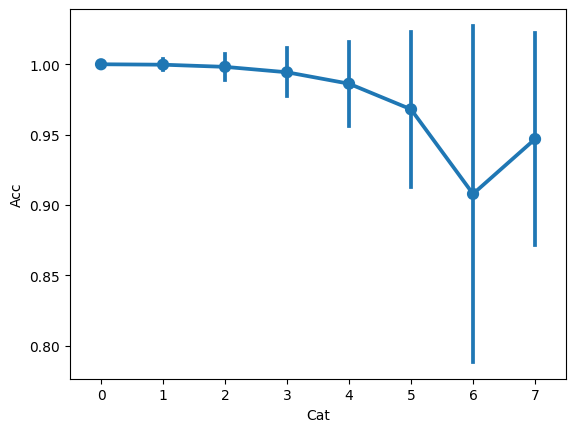

In [ ]:
sns.pointplot(data=df, x="Cat", y="Acc", ci="sd", )

<AxesSubplot:xlabel='Cat', ylabel='Acc'>

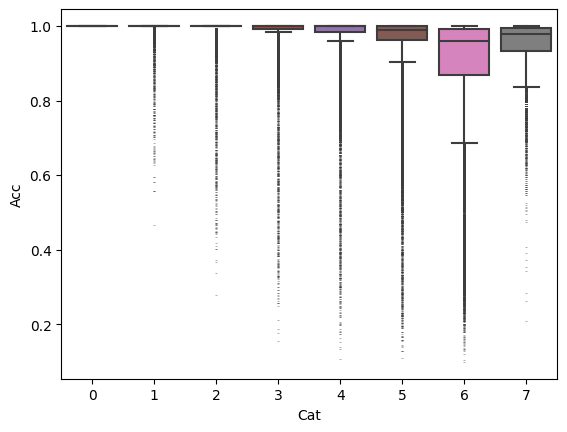

In [ ]:
# plt.figure(figsize=(18, 6))
sns.boxplot(data=df, y="Acc", x="Cat", fliersize=0.1)

### IoU for reconstructed mutations

In [160]:
cols_rec_obs = ["Mut", "Label", "PosInGene", "ProbaFull", "AltNode"]
cols_gt_obs  = ["Mut", "Label", "PosInGene", "AltNode"]

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}


def obs_iou(cond, pcutoff=0.3, cat_cutoff=4,  only_raw=False):
    path_to_rates   = f"../data/alisim/spectra_reconstructed_mam/{cond}/IQTREE/anc.rate"
    path_to_mapping = f"../data/alisim/spectra_reconstructed_mam/{cond}/sequences/species_mapping.txt"

    path_to_rec_obs = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/mutations.tsv"
    path_to_gt_obs  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutations.tsv"

    if os.path.exists(path_to_mapping) and os.path.exists(path_to_rec_obs) and os.path.exists(path_to_gt_obs):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)

        rec_obs = pd.read_csv(path_to_rec_obs, sep="\t", usecols=cols_rec_obs)
        gt_obs  = pd.read_csv(path_to_gt_obs,  sep="\t", usecols=cols_gt_obs)
        rates   = pd.read_csv(path_to_rates,   sep="\t", comment="#")

        # rec_obs = rec_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        # gt_obs  = gt_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)

        # replace encoded node names
        gt_obs["AltNode"] = gt_obs.AltNode.map(name2id)

        obs_total = pd.merge(rec_obs, gt_obs, "outer", ["AltNode", "PosInGene", "Mut"], suffixes=["_rec", "_gt"])
        obs_total  = obs_total.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)

        if only_raw:
            # return rec_obs, gt_obs
            return obs_total

        #prepare OBS
        rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat >= cat_cutoff)]
        rec_obs_syn = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 1) & (rec_obs.Cat >= cat_cutoff)]
        gt_obs_all = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)
        gt_obs_syn = gt_obs[(gt_obs.Label >= 1) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)

        if only_raw:
            return rec_obs_all, gt_obs_all, rec_obs_syn, gt_obs_syn




In [167]:
one = obs_iou(samples[0], 0.3, 4, True)
one.head()

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat
0,A[A>C]C,0.0,0.112967,Node2,NaN,5,1
1,A[C>A]C,0.0,0.156031,Node4,0.0,5,1
2,A[A>C]C,0.0,0.083365,Node3,NaN,5,1
3,A[A>C]C,0.0,0.134170,RN_4,NaN,5,1
4,A[C>A]C,0.0,0.081838,Node5,NaN,5,1


In [169]:
one["IsRec"] = (~one.Label_rec.isna()).astype(np.int8)
one["IsGt"] = (~one.Label_gt.isna()).astype(np.int8)
one["InterCat"] = one.IsRec + one.IsGt * 2 + (one.IsRec == one.IsGt).astype(np.int8)

one["Label"] = np.where(one.Label_gt.isna(), one.Label_rec, one.Label_gt)

In [187]:
one

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat,IsRec,IsGt,InterCat,Label
0,A[A>C]C,0.0,0.112967,Node2,NaN,5,1,1,0,1,0.0
1,A[C>A]C,0.0,0.156031,Node4,0.0,5,1,1,1,4,0.0
2,A[A>C]C,0.0,0.083365,Node3,NaN,5,1,1,0,1,0.0
3,A[A>C]C,0.0,0.134170,RN_4,NaN,5,1,1,0,1,0.0
4,A[C>A]C,0.0,0.081838,Node5,NaN,5,1,1,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
746337,T[T>G]G,2.0,0.959077,RN_2136,2.0,363,1,1,1,4,2.0
746338,T[T>G]T,2.0,0.945688,Node860,2.0,363,1,1,1,4,2.0
746339,T[T>G]T,2.0,0.971694,RN_843,2.0,363,1,1,1,4,2.0
746340,T[T>G]T,2.0,0.989169,RN_3932,2.0,363,1,1,1,4,2.0


In [242]:
x = one[one.ProbaFull > 0.3].groupby(["InterCat", "Cat"]).ProbaFull.sum().unstack()
x.T / x.sum(axis=1)

InterCat,1,4
Cat,,
1,0.013750,0.042824
2,0.048164,0.109730
3,0.097808,0.157495
4,0.154162,0.196504
5,0.294371,0.260643
6,0.391744,0.232805


In [232]:
sns.boxplot(data=one[one.ProbaFull > 0.3], )

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat,IsRec,IsGt,InterCat,Label
6,A[A>T]C,0.0,0.581261,Node1165,0.0,5,1,1,1,4,0.0
7,A[A>C]C,0.0,0.878062,RN_34,0.0,5,1,1,1,4,0.0
8,A[A>C]C,0.0,0.850641,RN_2346,0.0,5,1,1,1,4,0.0
9,A[A>T]C,0.0,0.862363,Node2431,0.0,5,1,1,1,4,0.0
11,C[A>C]C,0.0,0.557711,Node720,0.0,5,1,1,1,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
746334,T[T>G]G,2.0,0.915844,RN_1510,2.0,363,1,1,1,4,2.0
746337,T[T>G]G,2.0,0.959077,RN_2136,2.0,363,1,1,1,4,2.0
746338,T[T>G]T,2.0,0.945688,Node860,2.0,363,1,1,1,4,2.0
746339,T[T>G]T,2.0,0.971694,RN_843,2.0,363,1,1,1,4,2.0


In [188]:
one.groupby(["InterCat"]).ProbaFull.agg(["mean", "std"])

,mean,std
InterCat,,
1,0.207197,0.204349
2,NaN,NaN
4,0.743699,0.296585


In [202]:
one[one.ProbaFull > 0.3].groupby(["InterCat"]).Cat.value_counts(normalize=True).unstack()

Cat,1,2,3,4,5,6
InterCat,,,,,,
1,0.013303,0.047734,0.099258,0.153991,0.299345,0.386369
4,0.040927,0.105913,0.154803,0.194278,0.264347,0.239732


In [203]:
one[one.ProbaFull > 0.3].groupby(["InterCat"]).Label.value_counts(normalize=True).unstack()

Label,-3.0,-2.0,-1.0,0.0,1.0,2.0
InterCat,,,,,,
1,0.002926,0.067753,0.049719,0.725405,0.018434,0.135764
4,0.002219,0.055087,0.056756,0.728837,0.017534,0.139568


In [222]:
x = one[(one.ProbaFull > 0.3) & (one.Label >= 0)].groupby(["InterCat", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0)
x

Mut               A[A>C]A      A[A>C]C     A[A>C]G      A[A>C]T     A[A>G]A  \
InterCat Cat                                                                  
1        1      10.725331    10.123587    7.745973     4.529652    0.000000   
         2      86.949525    48.281531   30.919084    77.970676    7.287244   
         3     240.104565   129.000467   51.475055   107.849776   13.922884   
         4     349.810507   267.301232   63.949026   294.959874   12.798143   
         5     782.202447   581.153185  169.864017   467.577893   63.778130   
         6     853.306741   642.453622  162.370818   960.129651   94.071558   
4        1     129.023875    84.890575   66.035865   140.538412    4.307356   
         2     488.159635   326.745419  323.540156   489.445966   29.160167   
         3    1060.770745   612.516987  245.783789   540.033418   65.941941   
         4    1271.415642   956.859951  267.086788  1157.216022   71.405220   
         5    1864.059441  1622.618202  465.711891  1180.767434  127.694452   
         6    1343.955930  1147.709999  336.864856  1726.784915  106.529666   

Mut              A[A>G]C    A[A>G]G     A[A>G]T     A[A>T]A     A[A>T]C  ...  \
InterCat Cat                                                             ...   
1        1      0.000000   0.000000    1.495397    0.000000    0.000000  ...   
         2      5.169752   2.432227    4.235381    6.855590    8.684712  ...   
         3      7.002979   3.648313   12.657586   12.941848    5.901379  ...   
         4     19.480278   3.203167   29.796193   12.798126   12.142681  ...   
         5     64.843410  17.422728   52.560583   45.102130   32.948398  ...   
         6     87.866636  16.575756  142.744311   63.954649   59.651707  ...   
4        1      6.865741   4.764203   14.076288   12.772349    5.876642  ...   
         2     22.803544  20.844810   38.514465   51.301575   31.826132  ...   
         3     62.825105  12.810498   51.865300  104.525383   73.874850  ...   
         4     87.161018  17.179426  150.390609  151.389420  121.180504  ...   
         5    216.001797  38.051426  139.458183  200.858506  198.306129  ...   
         6    180.446441  45.696128  246.518653  166.474368  190.933621  ...   

Mut             T[T>A]G     T[T>A]T    T[T>C]A    T[T>C]C    T[T>C]G  \
InterCat Cat                                                           
1        1     1.824435    1.323786   1.724999   1.030638   0.000000   
         2     0.000000    3.048897   0.656403   1.222768   1.082343   
         3     3.364221    8.883802   1.405665   2.485193   3.315102   
         4     0.685581    3.949777   1.154909   2.291266   0.000000   
         5     7.285596   48.685714  16.491727   6.319741   3.104773   
         6     3.372236   12.882050   9.085819   4.057254   1.661541   
4        1    27.243095   74.679837  22.706930  13.733359   6.525567   
         2    13.327726   57.377170  36.872155  33.093445  24.132052   
         3    28.854624   93.249644  37.772399  24.547867  36.213713   
         4    14.954480   42.907610  22.898855  27.777351  11.361344   
         5    22.196587  264.249108  85.856335  59.892314  15.213599   
         6    16.318743   45.072253  43.195579  44.959188  10.727847   

Mut             T[T>C]T     T[T>G]A     T[T>G]C     T[T>G]G     T[T>G]T  
InterCat Cat                                                             
1        1     2.341077    8.551888    3.977213    3.274203    2.954896  
         2     0.749790   17.234164   11.921349    5.370280    5.463112  
         3     3.711440   17.918198   13.855264   13.237436   17.751521  
         4     1.109830   12.996621   15.530819    2.880863   10.381586  
         5    12.542178   74.595763   58.367914   12.189235   74.927133  
         6     3.578148   48.396684   27.720925   15.335823   16.894967  
4        1    30.028026   90.863551   68.290837   62.262258  101.421164  
         2    14.513016  180.334703  158.718612  100.741964   86.051588  
         3    35.187049

<AxesSubplot:xlabel='InterCat-Cat', ylabel='InterCat-Cat'>

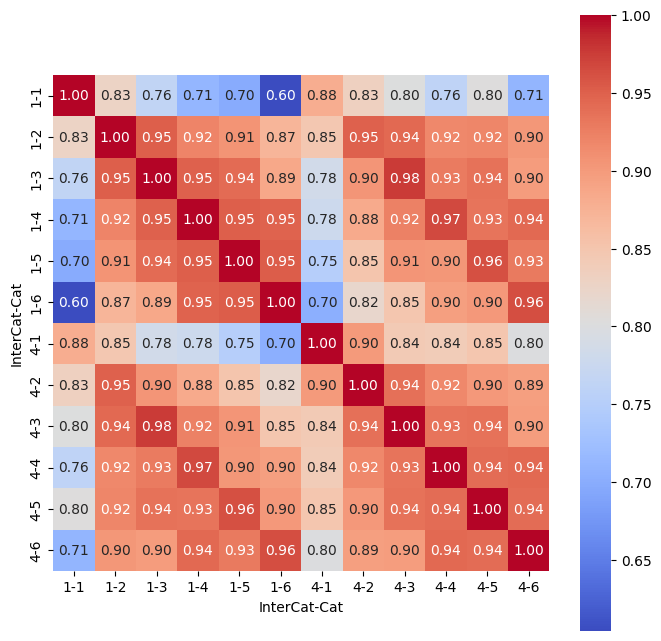

In [223]:
plt.figure(figsize=(8, 8))
sns.heatmap(pd.DataFrame(1-squareform(pdist(x, "cosine")), columns=x.index, index=x.index), cmap="coolwarm", annot=True, fmt=".2f", square=True)